In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/My Drive/LSTM_DL

/content/drive/My Drive/LSTM_DL


In [3]:
!pip install common
!pip install --upgrade pandas
!pip install --upgrade --force-reinstall xlrd

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for common: filename=common-0.1.2-py3-none-any.whl size=3731 sha256=f01c3b2e049912a34fab9f6c965013d335a84cb78fc061fb014bb825dded153f
  Stored in directory: /root/.cache/pip/wheels/ec/b0/bf/d38cbc0eb5079d61cc5e94280603e7b5756f502edc072c7319
Successfully built common
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.2 MB 28.3 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 5.4 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.2.0
    Uninstalling xlrd-1.2.0:
      Successfully uninstalled xlrd-1.2.0


#Data94

##data 94 전처리

In [7]:
# road data
data = pd.read_excel('data.xls')

data94 = data[(data['Part Number'] == 'Part 94')]

# clear data
data94 = data94.loc[:, ['Part Number', 'D일 투입예정 수량(D일계획)', 'D+1일 투입예정 수량(Total)', 'D+2일 투입예정 수량(Total)',
                        'D+3일 투입예정 수량(Total)', 'D+4일 투입예정 수량(Total)', 'D+5일 투입예정 수량', 'D+6일 투입예정 수량',
                        'D+7일 투입예정 수량', 'D+8일 투입예정 수량', 'D+9일 투입예정 수량', 'D+10일 투입예정 수량', 'D+11일 투입예정 수량',
                        'D+12일 투입예정 수량','CRET_TIME']]

In [8]:
data94['CRET_TIME'] = pd.to_datetime(data94['CRET_TIME'], format="%Y%m%d%H%M")

data94 = data94.groupby(by=[data94['CRET_TIME'].dt.year,
data94['CRET_TIME'].dt.month,
data94['CRET_TIME'].dt.day]).last()
data94.reset_index(drop=True, inplace=True)

##변수별 상관관계 파악을 위한 데이터 재배열

In [9]:
corr_data94 = pd.concat([
        data94.iloc[12:, :]['D일 투입예정 수량(D일계획)'].reset_index(drop=True),
        data94.iloc[11:-1, :]['D+1일 투입예정 수량(Total)'].reset_index(drop=True),
        data94.iloc[10:-2, :]['D+2일 투입예정 수량(Total)'].reset_index(drop=True),
        data94.iloc[9:-3, :]['D+3일 투입예정 수량(Total)'].reset_index(drop=True),
        data94.iloc[8:-4, :]['D+4일 투입예정 수량(Total)'].reset_index(drop=True),
        data94.iloc[7:-5, :]['D+5일 투입예정 수량'].reset_index(drop=True),
        data94.iloc[6:-6, :]['D+6일 투입예정 수량'].reset_index(drop=True),
        data94.iloc[5:-7, :]['D+7일 투입예정 수량'].reset_index(drop=True),
        data94.iloc[4:-8, :]['D+8일 투입예정 수량'].reset_index(drop=True),
        data94.iloc[3:-9, :]['D+9일 투입예정 수량'].reset_index(drop=True),
        data94.iloc[2:-10, :]['D+10일 투입예정 수량'].reset_index(drop=True),
        data94.iloc[1:-11, :]['D+11일 투입예정 수량'].reset_index(drop=True),
        data94.iloc[:-12, :]['D+12일 투입예정 수량'].reset_index(drop=True)
        ],
        axis=1)


##당일 발주 수량과 가장 유의미한 관계가 있는 변수선택

In [10]:
data94 = data94.loc[:, ['D일 투입예정 수량(D일계획)',
                  'D+3일 투입예정 수량(Total)',
                  'D+4일 투입예정 수량(Total)',
                  'D+5일 투입예정 수량'
                  ]].reset_index(drop=True)
data94.head()

,D일 투입예정 수량(D일계획),D+3일 투입예정 수량(Total),D+4일 투입예정 수량(Total),D+5일 투입예정 수량
0,42,30,30,38
1,40,30,50,45
2,40,47,43,51
3,47,53,42,39
4,46,44,37,51


##사용자 지정함수로 시계열 데이터로 변환

In [11]:
def to_timeseries_data(data, lookback=3, delay=3):
    # data는 원본 tabular 데이터
    # lookback: 입력으로 사용하기 위해 거슬러 올라갈 시간단위의 개수=3일전
    # delay: target으로 사용할 미래의 시점=3일후
    output_len = len(data)-(lookback+delay)+1 # N=total_length-(3+3)+1
    n_feature = data.shape[-1] # =4
    
    inputs = np.zeros((output_len, lookback, n_feature)) # (N,3,4)
    targets = np.zeros((output_len,)) # (N,)
    
    for i in range(output_len):
        inputs[i] = data.iloc[i:i+lookback, :]
        targets[i] = data.iloc[i+lookback+delay-1, 0]
       
    return inputs, targets
# 사용자 정의 함수 적용
X_94, y_94 = to_timeseries_data(data94)
print("X의 형태: ", X_94.shape)
print("y의 형태: ", y_94.shape)

X의 형태:  (44, 3, 4)
y의 형태:  (44,)


##데이터셋 분리와 데이터 스케일링

In [12]:
# 데이터셋 분리, train:validation:test = 7:1:2
X_train_94, X_val_94, X_test_94 = np.split(X_94, [int(0.7*len(X_94)), int(0.8*len(X_94))])
y_train_94, y_val_94, y_test_94 = np.split(y_94, [int(0.7*len(y_94)), int(0.8*len(y_94))])
# 분리 이후 데이터 형태
print("X 학습: {}, X 검증: {}, X 평가: {}".format(X_train_94.shape,X_val_94.shape,X_test_94.shape))
print("y 학습: {}, y 검증: {}, y 평가: {}".format(y_train_94.shape,y_val_94.shape,y_test_94.shape))


X 학습: (30, 3, 4), X 검증: (5, 3, 4), X 평가: (9, 3, 4)
y 학습: (30,), y 검증: (5,), y 평가: (9,)


In [13]:
# 전처리시 필요한 패키지 불러오기
from sklearn.preprocessing import StandardScaler
Xscaler_94 = StandardScaler()
X_train_94 = Xscaler_94.fit_transform(X_train_94.reshape(-1, X_train_94.shape[-1])).reshape(X_train_94.shape)
X_val_94 = Xscaler_94.transform(X_val_94.reshape(-1, X_val_94.shape[-1])).reshape(X_val_94.shape)
X_test_94 = Xscaler_94.transform(X_test_94.reshape(-1, X_test_94.shape[-1])).reshape(X_test_94.shape)
yscaler_94 = StandardScaler()
y_train_94 = yscaler_94.fit_transform(y_train_94.reshape(-1,1))
y_val_94 = yscaler_94.transform(y_val_94.reshape(-1,1))
y_test_94 = yscaler_94.transform(y_test_94.reshape(-1,1))

#LSTM Model Definition

In [ ]:
#!pip uninstall tensorflow -y
#!pip install tensorflow==2.10.0

In [14]:
import uuid
import tensorflow as tf

from keras import activations
from keras import backend
from keras import constraints
from keras import initializers
from keras import regularizers
from keras.engine import base_layer
#from keras.engine.input_spec import InputSpec
from keras.engine.input_spec import InputSpec
from keras.layers.rnn import gru_lstm_utils
from keras.layers.rnn import rnn_utils
from keras.layers.rnn import RNN
# from keras.layers.rnn.dropout_rnn_cell_mixin import DropoutRNNCellMixin
from keras.utils import tf_utils
from keras.layers.rnn.dropout_rnn_cell_mixin import DropoutRNNCellMixin

# isort: off
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.util.tf_export import keras_export

In [15]:
class LSTMCell(DropoutRNNCellMixin, base_layer.BaseRandomLayer):
    def __init__(
        self,
        units,
        activation="tanh",
        recurrent_activation="sigmoid",
        use_bias=True,
        kernel_initializer="glorot_uniform",
        recurrent_initializer="orthogonal",
        bias_initializer="zeros",
        unit_forget_bias=True,
        kernel_regularizer=None,
        recurrent_regularizer=None,
        bias_regularizer=None,
        kernel_constraint=None,
        recurrent_constraint=None,
        bias_constraint=None,
        dropout=0.0,
        recurrent_dropout=0.0,
        **kwargs,
    ):
        if units < 0:
            raise ValueError(
                f"Received an invalid value for argument `units`, "
                f"expected a positive integer, got {units}."
            )
        # By default use cached variable under v2 mode, see b/143699808.
        if tf.compat.v1.executing_eagerly_outside_functions():
            self._enable_caching_device = kwargs.pop(
                "enable_caching_device", True
            )
        else:
            self._enable_caching_device = kwargs.pop(
                "enable_caching_device", False
            )
        super().__init__(**kwargs)
        self.units = units  
        self.activation = activations.get(activation)   #활성함수
        self.recurrent_activation = activations.get(recurrent_activation)   #순환단계에서의 활성함수
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)   #가중치 초기값
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)   #편향백터 초기값
        self.unit_forget_bias = unit_forget_bias 

        self.kernel_regularizer = regularizers.get(kernel_regularizer)   #가중치 행렬의 초기값
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer) #가중치 행렬의 적용되는 정규화
        self.bias_regularizer = regularizers.get(bias_regularizer)   #편향백터의 적용되는 정규화 함수

        self.kernel_constraint = constraints.get(kernel_constraint) #가중치 행렬의 제약 함수
        self.recurrent_constraint = constraints.get(recurrent_constraint) #가중치 행렬의 제약 함수
        self.bias_constraint = constraints.get(bias_constraint)  #편향백터에 적용되는 제약함수

        self.dropout = min(1.0, max(0.0, dropout)) #0과 1사이 부동소수점. 인풋의 선형적 변형을 실행하는데 드롭시킬(고려하지 않을) 유닛의 비율.
        self.recurrent_dropout = min(1.0, max(0.0, recurrent_dropout)) #0과 1사이 부동소수점. 순환 상태의 선형적 변형을 실행하는데 드롭시킬(고려하지 않을) 유닛의 비율.
        implementation = kwargs.pop("implementation", 2)
        if self.recurrent_dropout != 0 and implementation != 1:
            logging.debug(RECURRENT_DROPOUT_WARNING_MSG)
            self.implementation = 1
        else:
            self.implementation = implementation
        self.state_size = [self.units, self.units]
        self.output_size = self.units

    @tf_utils.shape_type_conversion
    def build(self, input_shape):
        super().build(input_shape)
        default_caching_device = rnn_utils.caching_device(self)
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(
            shape=(input_dim, self.units * 4),
            name="kernel",
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            caching_device=default_caching_device,
        )
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units * 4),
            name="recurrent_kernel",
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint,
            caching_device=default_caching_device,
        )

        if self.use_bias:
            if self.unit_forget_bias:

                def bias_initializer(_, *args, **kwargs):
                    return backend.concatenate(
                        [
                            self.bias_initializer(
                                (self.units,), *args, **kwargs
                            ),
                            initializers.get("ones")(
                                (self.units,), *args, **kwargs
                            ),
                            self.bias_initializer(
                                (self.units * 2,), *args, **kwargs
                            ),
                        ]
                    )

            else:
                bias_initializer = self.bias_initializer
            self.bias = self.add_weight(
                shape=(self.units * 4,),
                name="bias",
                initializer=bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                caching_device=default_caching_device,
            )
        else:
            self.bias = None
        self.built = True

###############################################주요함수부분###################################################################################################

    def _compute_carry_and_output(self, x, h_tm1, c_tm1):
        """Computes carry and output using split kernels."""
        x_i, x_f, x_c, x_o = x 
        h_tm1_i, h_tm1_f, h_tm1_c, h_tm1_o = h_tm1
        i = self.recurrent_activation(
            x_i + backend.dot(h_tm1_i, self.recurrent_kernel[:, : self.units]) 
        ) #input gate 시그모이드 함수 적용 
        f = self.recurrent_activation(
            x_f
            + backend.dot(
                h_tm1_f, self.recurrent_kernel[:, self.units : self.units * 2]
            )
        ) #forget gate 시그모이드 함수 적용
        c = f * c_tm1 + i * self.activation(
            x_c
            + backend.dot(
                h_tm1_c,
                self.recurrent_kernel[:, self.units * 2 : self.units * 3],
            )
        ) 
        o = self.recurrent_activation(
            x_o
            + backend.dot(h_tm1_o, self.recurrent_kernel[:, self.units * 3 :])
        )
        return c, o

    def _compute_carry_and_output_fused(self, z, c_tm1):
        """Computes carry and output using fused kernels."""
        z0, z1, z2, z3 = z
        i = self.recurrent_activation(z0)
        f = self.recurrent_activation(z1)
        c = f * c_tm1 + i * self.activation(z2)
        o = self.recurrent_activation(z3)
        return c, o

    def call(self, inputs, states, training=None):
        h_tm1 = states[0]  # previous memory state
        c_tm1 = states[1]  # previous carry state

        dp_mask = self.get_dropout_mask_for_cell(inputs, training, count=4)
        rec_dp_mask = self.get_recurrent_dropout_mask_for_cell(
            h_tm1, training, count=4
        )

        if self.implementation == 1:
            if 0 < self.dropout < 1.0:
                inputs_i = inputs * dp_mask[0]
                inputs_f = inputs * dp_mask[1]
                inputs_c = inputs * dp_mask[2]
                inputs_o = inputs * dp_mask[3]
            else:
                inputs_i = inputs
                inputs_f = inputs
                inputs_c = inputs
                inputs_o = inputs
            k_i, k_f, k_c, k_o = tf.split(
                self.kernel, num_or_size_splits=4, axis=1
            )
            x_i = backend.dot(inputs_i, k_i)
            x_f = backend.dot(inputs_f, k_f)
            x_c = backend.dot(inputs_c, k_c)
            x_o = backend.dot(inputs_o, k_o)
            if self.use_bias:
                b_i, b_f, b_c, b_o = tf.split(
                    self.bias, num_or_size_splits=4, axis=0
                )
                x_i = backend.bias_add(x_i, b_i)
                x_f = backend.bias_add(x_f, b_f)
                x_c = backend.bias_add(x_c, b_c)
                x_o = backend.bias_add(x_o, b_o)

            if 0 < self.recurrent_dropout < 1.0:
                h_tm1_i = h_tm1 * rec_dp_mask[0]
                h_tm1_f = h_tm1 * rec_dp_mask[1]
                h_tm1_c = h_tm1 * rec_dp_mask[2]
                h_tm1_o = h_tm1 * rec_dp_mask[3]
            else:
                h_tm1_i = h_tm1
                h_tm1_f = h_tm1
                h_tm1_c = h_tm1
                h_tm1_o = h_tm1
            x = (x_i, x_f, x_c, x_o)
            h_tm1 = (h_tm1_i, h_tm1_f, h_tm1_c, h_tm1_o)
            c, o = self._compute_carry_and_output(x, h_tm1, c_tm1)
        else:
            if 0.0 < self.dropout < 1.0:
                inputs = inputs * dp_mask[0]
            z = backend.dot(inputs, self.kernel)
            z += backend.dot(h_tm1, self.recurrent_kernel)
            if self.use_bias:
                z = backend.bias_add(z, self.bias)

            z = tf.split(z, num_or_size_splits=4, axis=1)
            c, o = self._compute_carry_and_output_fused(z, c_tm1)

        h = o * self.activation(c)
        return h, [h, c]


    def get_config(self):
        config = {
            "units": self.units,
            "activation": activations.serialize(self.activation),
            "recurrent_activation": activations.serialize(
                self.recurrent_activation
            ),
            "use_bias": self.use_bias,
            "kernel_initializer": initializers.serialize(
                self.kernel_initializer
            ),
            "recurrent_initializer": initializers.serialize(
                self.recurrent_initializer
            ),
            "bias_initializer": initializers.serialize(self.bias_initializer),
            "unit_forget_bias": self.unit_forget_bias,
            "kernel_regularizer": regularizers.serialize(
                self.kernel_regularizer
            ),
            "recurrent_regularizer": regularizers.serialize(
                self.recurrent_regularizer
            ),
            "bias_regularizer": regularizers.serialize(self.bias_regularizer),
            "kernel_constraint": constraints.serialize(self.kernel_constraint),
            "recurrent_constraint": constraints.serialize(
                self.recurrent_constraint
            ),
            "bias_constraint": constraints.serialize(self.bias_constraint),
            "dropout": self.dropout,
            "recurrent_dropout": self.recurrent_dropout,
            "implementation": self.implementation,
        }
        config.update(rnn_utils.config_for_enable_caching_device(self))
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return list(
            rnn_utils.generate_zero_filled_state_for_cell(
                self, inputs, batch_size, dtype
            )
        )

In [16]:
class LSTM(DropoutRNNCellMixin, RNN, base_layer.BaseRandomLayer):
    def __init__(
        self,
        units,
        activation="tanh",
        recurrent_activation="sigmoid",
        use_bias=True,
        kernel_initializer="glorot_uniform",
        recurrent_initializer="orthogonal",
        bias_initializer="zeros",
        unit_forget_bias=True,
        kernel_regularizer=None,
        recurrent_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        recurrent_constraint=None,
        bias_constraint=None,
        dropout=0.0,
        recurrent_dropout=0.0,
        return_sequences=False,
        return_state=False,
        go_backwards=False,
        stateful=False,
        time_major=False,
        unroll=False,
        **kwargs,
    ):
  
        # return_runtime is a flag for testing, which shows the real backend
        # implementation chosen by grappler in graph mode.
        self.return_runtime = kwargs.pop("return_runtime", False)
        implementation = kwargs.pop("implementation", 2)
        if implementation == 0:
            logging.warning(
                "`implementation=0` has been deprecated, "
                "and now defaults to `implementation=1`."
                "Please update your layer call."
            )
        if "enable_caching_device" in kwargs:
            cell_kwargs = {
                "enable_caching_device": kwargs.pop("enable_caching_device")
            }
        else:
            cell_kwargs = {}
        cell = LSTMCell(
            units,
            activation=activation,
            recurrent_activation=recurrent_activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            recurrent_initializer=recurrent_initializer,
            unit_forget_bias=unit_forget_bias,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            recurrent_regularizer=recurrent_regularizer,
            bias_regularizer=bias_regularizer,
            kernel_constraint=kernel_constraint,
            recurrent_constraint=recurrent_constraint,
            bias_constraint=bias_constraint,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            implementation=implementation,
            dtype=kwargs.get("dtype"),
            trainable=kwargs.get("trainable", True),
            **cell_kwargs,
        )
        super().__init__(
            cell,
            return_sequences=return_sequences,
            return_state=return_state,
            go_backwards=go_backwards,
            stateful=stateful,
            time_major=time_major,
            unroll=unroll,
            **kwargs,
        )
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.input_spec = [InputSpec(ndim=3)]
        self.state_spec = [
            InputSpec(shape=(None, dim)) for dim in (self.units, self.units)
        ]
        self._could_use_gpu_kernel = (
            self.activation in (activations.tanh, tf.tanh)
            and self.recurrent_activation in (activations.sigmoid, tf.sigmoid)
            and recurrent_dropout == 0
            and not unroll
            and use_bias
            and tf.compat.v1.executing_eagerly_outside_functions()
        )
        if tf.config.list_logical_devices("GPU"):
            # Only show the message when there is GPU available, user will not
            # care about the cuDNN if there isn't any GPU.
            if self._could_use_gpu_kernel:
                logging.debug(gru_lstm_utils.CUDNN_AVAILABLE_MSG % self.name)
            else:
                logging.warning(
                    gru_lstm_utils.CUDNN_NOT_AVAILABLE_MSG % self.name
                )

        if gru_lstm_utils.use_new_gru_lstm_impl():
            self._defun_wrapper = gru_lstm_utils.DefunWrapper(
                time_major, go_backwards, "lstm"
            )

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'units': self.units,
            'activation': self.activation,
            'recurrent_activation': self.recurrent_activation,
            'use_bias': self.use_bias,
            'kernel_initializer': self.kernel_initializer,
            'recurrent_initializer': self.recurrent_initializer,
            'bias_initializer': self.bias_initializer,
            'unit_forget_bias': self.unit_forget_bias,
            'kernel_regularizer':self.kernel_regularizer,
            'recurrent_regularizer':self.recurrent_regularizer,
            'bias_regularizer':self.bias_regularizer,
            'activity_regularizer':self.activity_regularizerr,
            'kernel_constraint':self.kernel_constraint,
            'recurrent_constraint':self.recurrent_constraint,
            'bias_constraint':self.bias_constraint,
            'dropout':self.dropout,
            'recurrent_dropout':self.recurrent_dropou,
            'return_sequences':self.return_sequences,
            'return_state':self.return_state,
            'go_backwards':self.go_backwards,
            'stateful':self.stateful,
            'time_major':self.time_major,
            'unroll':self.unroll,
        })
        return config


    def call(self, inputs, mask=None, training=None, initial_state=None):
        # The input should be dense, padded with zeros. If a ragged input is fed
        # into the layer, it is padded and the row lengths are used for masking.
        inputs, row_lengths = backend.convert_inputs_if_ragged(inputs)
        is_ragged_input = row_lengths is not None
        self._validate_args_if_ragged(is_ragged_input, mask)

        # LSTM does not support constants. Ignore it during process.
        inputs, initial_state, _ = self._process_inputs(
            inputs, initial_state, None
        )

        if isinstance(mask, list):
            mask = mask[0]

        input_shape = backend.int_shape(inputs)
        timesteps = input_shape[0] if self.time_major else input_shape[1]

        if not self._could_use_gpu_kernel:
            # Fall back to use the normal LSTM.
            kwargs = {"training": training}
            self._maybe_reset_cell_dropout_mask(self.cell)

            def step(inputs, states):
                return self.cell(inputs, states, **kwargs)

            last_output, outputs, states = backend.rnn(
                step,
                inputs,
                initial_state,
                constants=None,
                go_backwards=self.go_backwards,
                mask=mask,
                unroll=self.unroll,
                input_length=row_lengths
                if row_lengths is not None
                else timesteps,
                time_major=self.time_major,
                zero_output_for_mask=self.zero_output_for_mask,
                return_all_outputs=self.return_sequences,
            )
            runtime = gru_lstm_utils.runtime(gru_lstm_utils.RUNTIME_UNKNOWN)
        else:
            # Use the new defun approach for backend implementation swap.
            # Note that different implementations need to have same function
            # signature, eg, the tensor parameters need to have same shape and
            # dtypes. Since the cuDNN has an extra set of bias, those bias will
            # be passed to both normal and cuDNN implementations.
            self.reset_dropout_mask()
            dropout_mask = self.get_dropout_mask_for_cell(
                inputs, training, count=4
            )
            if dropout_mask is not None:
                inputs = inputs * dropout_mask[0]
            if gru_lstm_utils.use_new_gru_lstm_impl():
                lstm_kwargs = {
                    "inputs": inputs,
                    "init_h": gru_lstm_utils.read_variable_value(
                        initial_state[0]
                    ),
                    "init_c": gru_lstm_utils.read_variable_value(
                        initial_state[1]
                    ),
                    "kernel": gru_lstm_utils.read_variable_value(
                        self.cell.kernel
                    ),
                    "recurrent_kernel": gru_lstm_utils.read_variable_value(
                        self.cell.recurrent_kernel
                    ),
                    "bias": gru_lstm_utils.read_variable_value(self.cell.bias),
                    "mask": mask,
                    "time_major": self.time_major,
                    "go_backwards": self.go_backwards,
                    "sequence_lengths": row_lengths,
                    "zero_output_for_mask": self.zero_output_for_mask,
                }
                (
                    last_output,
                    outputs,
                    new_h,
                    new_c,
                    runtime,
                ) = self._defun_wrapper.defun_layer(**lstm_kwargs)
            else:
                gpu_lstm_kwargs = {
                    "inputs": inputs,
                    "init_h": gru_lstm_utils.read_variable_value(
                        initial_state[0]
                    ),
                    "init_c": gru_lstm_utils.read_variable_value(
                        initial_state[1]
                    ),
                    "kernel": gru_lstm_utils.read_variable_value(
                        self.cell.kernel
                    ),
                    "recurrent_kernel": gru_lstm_utils.read_variable_value(
                        self.cell.recurrent_kernel
                    ),
                    "bias": gru_lstm_utils.read_variable_value(self.cell.bias),
                    "mask": mask,
                    "time_major": self.time_major,
                    "go_backwards": self.go_backwards,
                    "sequence_lengths": row_lengths,
                    "return_sequences": self.return_sequences,
                }
                normal_lstm_kwargs = gpu_lstm_kwargs.copy()
                normal_lstm_kwargs.update(
                    {
                        "zero_output_for_mask": self.zero_output_for_mask,
                    }
                )

                if tf.executing_eagerly():
                    device_type = gru_lstm_utils.get_context_device_type()
                    can_use_gpu = (
                        # Either user specified GPU or unspecified but GPU is
                        # available.
                        (
                            device_type == gru_lstm_utils.GPU_DEVICE_NAME
                            or (
                                device_type is None
                                and tf.config.list_logical_devices("GPU")
                            )
                        )
                        and (
                            mask is None
                            or gru_lstm_utils.is_cudnn_supported_inputs(
                                mask, self.time_major
                            )
                        )
                    )
                    # Under eager context, check the device placement and prefer
                    # the GPU implementation when GPU is available.
                    if can_use_gpu:
                        last_output, outputs, new_h, new_c, runtime = gpu_lstm(
                            **gpu_lstm_kwargs
                        )
                    else:
                        (
                            last_output,
                            outputs,
                            new_h,
                            new_c,
                            runtime,
                        ) = standard_lstm(**normal_lstm_kwargs)
                else:
                    (
                        last_output,
                        outputs,
                        new_h,
                        new_c,
                        runtime,
                    ) = lstm_with_backend_selection(**normal_lstm_kwargs)

            states = [new_h, new_c]

        if self.stateful:
            updates = [
                tf.compat.v1.assign(
                    self_state, tf.cast(state, self_state.dtype)
                )
                for self_state, state in zip(self.states, states)
            ]
            self.add_update(updates)

        if self.return_sequences:
            output = backend.maybe_convert_to_ragged(
                is_ragged_input,
                outputs,
                row_lengths,
                go_backwards=self.go_backwards,
            )
        else:
            output = last_output

        if self.return_state:
            return [output] + list(states)
        elif self.return_runtime:
            return output, runtime
        else:
            return output

    @property
    def units(self):
        return self.cell.units
    

    @property
    def activation(self):
        return self.cell.activation

    @property
    def recurrent_activation(self):
        return self.cell.recurrent_activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def unit_forget_bias(self):
        return self.cell.unit_forget_bias

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    @property
    def implementation(self):
        return self.cell.implementation

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    @classmethod
    def from_config(cls, config):
        if "implementation" in config and config["implementation"] == 0:
            config["implementation"] = 1
        return cls(**config)

#data 94 Build Model

In [17]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

In [18]:
model = Sequential()
model.add(LSTM(8, dropout=0.2, activation='relu', input_shape=(3, 4), return_sequences=True))
model.add(LSTM(8, dropout=0.2, activation='relu'))
model.add(Dense(1, activation='linear'))

In [19]:
model.compile(optimizer='adam', loss='mae')

In [20]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
model_path = './model/{epoch:02d}-{val_loss:.4f}.hdf5'
callbacks = [EarlyStopping(monitor='val_loss', patience=15),
               ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=0, save_best_only=True)]
history = model.fit(X_train_94, y_train_94, epochs=100, batch_size=4, validation_data=(X_val_94, y_val_94))

Epoch 1/100
8/8 [==============================] - 5s 67ms/step - loss: 0.8041 - val_loss: 0.8461
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.7948 - val_loss: 0.8455
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.7918 - val_loss: 0.8443
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 0.7919 - val_loss: 0.8434
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.7896 - val_loss: 0.8433
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 0.7858 - val_loss: 0.8430
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 0.7846 - val_loss: 0.8432
Epoch 8/100
8/8 [==============================] - 0s 9ms/step - loss: 0.7841 - val_loss: 0.8444
Epoch 9/100
8/8 [==============================] - 0s 8ms/step - loss: 0.7849 - val_loss: 0.8439
Epoch 10/100
8/8 [==============================] - 0s 8ms/step - loss: 0.7882 - val_loss: 0.8430
Epoch 11/100
8/8 [==========

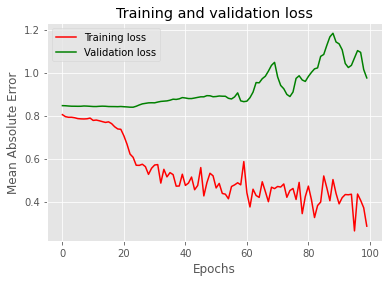

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = history.epoch
plt.figure()
plt.plot(epoch, loss, 'r', label='Training loss')
plt.plot(epoch, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [22]:
loss_and_metrics = model.evaluate(X_test_94,y_test_94)
print('##### data 94 #####')
print('loss : ',loss_and_metrics)

1/1 [==============================] - 0s 31ms/step - loss: 1.1361
##### data 94 #####
loss :  1.1360572576522827


#Data 60 66 에대한 전처리

In [23]:
# road data
data = pd.read_excel('data.xls')

data60 = data[(data['Part Number'] == 'Part 60')]
data66 = data[(data['Part Number'] == 'Part 66')]

# clear data
data60 = data60.loc[:, ['Part Number', 'D일 투입예정 수량(D일계획)', 'D+1일 투입예정 수량(Total)', 'D+2일 투입예정 수량(Total)',
                        'D+3일 투입예정 수량(Total)', 'D+4일 투입예정 수량(Total)', 'D+5일 투입예정 수량', 'D+6일 투입예정 수량',
                        'D+7일 투입예정 수량', 'D+8일 투입예정 수량', 'D+9일 투입예정 수량', 'D+10일 투입예정 수량', 'D+11일 투입예정 수량',
                        'D+12일 투입예정 수량','CRET_TIME']]
data66 = data66.loc[:, ['Part Number', 'D일 투입예정 수량(D일계획)', 'D+1일 투입예정 수량(Total)', 'D+2일 투입예정 수량(Total)',
                        'D+3일 투입예정 수량(Total)', 'D+4일 투입예정 수량(Total)', 'D+5일 투입예정 수량', 'D+6일 투입예정 수량',
                        'D+7일 투입예정 수량', 'D+8일 투입예정 수량', 'D+9일 투입예정 수량', 'D+10일 투입예정 수량', 'D+11일 투입예정 수량',
                        'D+12일 투입예정 수량','CRET_TIME']]

In [24]:
data60['CRET_TIME'] = pd.to_datetime(data60['CRET_TIME'], format="%Y%m%d%H%M")
data66['CRET_TIME'] = pd.to_datetime(data66['CRET_TIME'], format="%Y%m%d%H%M")

data60 = data60.groupby(by=[data60['CRET_TIME'].dt.year,
data60['CRET_TIME'].dt.month,
data60['CRET_TIME'].dt.day]).last()
data60.reset_index(drop=True, inplace=True)

data66 = data66.groupby(by=[data66['CRET_TIME'].dt.year,
data66['CRET_TIME'].dt.month,
data66['CRET_TIME'].dt.day]).last()
data66.reset_index(drop=True, inplace=True)

##변수별 상관관계 파악을 위한 데이터 재배열

In [25]:
corr_data60 = pd.concat([
        data60.iloc[12:, :]['D일 투입예정 수량(D일계획)'].reset_index(drop=True),
        data60.iloc[11:-1, :]['D+1일 투입예정 수량(Total)'].reset_index(drop=True),
        data60.iloc[10:-2, :]['D+2일 투입예정 수량(Total)'].reset_index(drop=True),
        data60.iloc[9:-3, :]['D+3일 투입예정 수량(Total)'].reset_index(drop=True),
        data60.iloc[8:-4, :]['D+4일 투입예정 수량(Total)'].reset_index(drop=True),
        data60.iloc[7:-5, :]['D+5일 투입예정 수량'].reset_index(drop=True),
        data60.iloc[6:-6, :]['D+6일 투입예정 수량'].reset_index(drop=True),
        data60.iloc[5:-7, :]['D+7일 투입예정 수량'].reset_index(drop=True),
        data60.iloc[4:-8, :]['D+8일 투입예정 수량'].reset_index(drop=True),
        data60.iloc[3:-9, :]['D+9일 투입예정 수량'].reset_index(drop=True),
        data60.iloc[2:-10, :]['D+10일 투입예정 수량'].reset_index(drop=True),
        data60.iloc[1:-11, :]['D+11일 투입예정 수량'].reset_index(drop=True),
        data60.iloc[:-12, :]['D+12일 투입예정 수량'].reset_index(drop=True)
        ],
        axis=1)

corr_data66 = pd.concat([
        data66.iloc[12:, :]['D일 투입예정 수량(D일계획)'].reset_index(drop=True),
        data66.iloc[11:-1, :]['D+1일 투입예정 수량(Total)'].reset_index(drop=True),
        data66.iloc[10:-2, :]['D+2일 투입예정 수량(Total)'].reset_index(drop=True),
        data66.iloc[9:-3, :]['D+3일 투입예정 수량(Total)'].reset_index(drop=True),
        data66.iloc[8:-4, :]['D+4일 투입예정 수량(Total)'].reset_index(drop=True),
        data66.iloc[7:-5, :]['D+5일 투입예정 수량'].reset_index(drop=True),
        data66.iloc[6:-6, :]['D+6일 투입예정 수량'].reset_index(drop=True),
        data66.iloc[5:-7, :]['D+7일 투입예정 수량'].reset_index(drop=True),
        data66.iloc[4:-8, :]['D+8일 투입예정 수량'].reset_index(drop=True),
        data66.iloc[3:-9, :]['D+9일 투입예정 수량'].reset_index(drop=True),
        data66.iloc[2:-10, :]['D+10일 투입예정 수량'].reset_index(drop=True),
        data66.iloc[1:-11, :]['D+11일 투입예정 수량'].reset_index(drop=True),
        data66.iloc[:-12, :]['D+12일 투입예정 수량'].reset_index(drop=True)
        ],
        axis=1)

##당일발주 수량과 가장 유의미한 관계가 있는 변수 선택

In [26]:
data60 = data60.loc[:, ['D일 투입예정 수량(D일계획)',
                  'D+3일 투입예정 수량(Total)',
                  'D+4일 투입예정 수량(Total)',
                  'D+5일 투입예정 수량'
                  ]].reset_index(drop=True)
data60.head()

,D일 투입예정 수량(D일계획),D+3일 투입예정 수량(Total),D+4일 투입예정 수량(Total),D+5일 투입예정 수량
0,898,832,832,832
1,932,872,0,0
2,961,0,0,837
3,1043,0,827,851
4,1124,0,0,0


In [27]:
data66 = data66.loc[:, ['D일 투입예정 수량(D일계획)',
                  'D+3일 투입예정 수량(Total)',
                  'D+4일 투입예정 수량(Total)',
                  'D+5일 투입예정 수량'
                  ]].reset_index(drop=True)
data66.head()

,D일 투입예정 수량(D일계획),D+3일 투입예정 수량(Total),D+4일 투입예정 수량(Total),D+5일 투입예정 수량
0,898,832,832,832
1,932,872,0,0
2,961,0,0,837
3,1043,0,827,851
4,1124,0,0,0


##사용자 지정함수로 시계열 데이터로 변환

In [28]:
def to_timeseries_data(data, lookback=3, delay=3):
    # data는 원본 tabular 데이터
    # lookback: 입력으로 사용하기 위해 거슬러 올라갈 시간단위의 개수=3일전
    # delay: target으로 사용할 미래의 시점=3일후
    output_len = len(data)-(lookback+delay)+1 # N=total_length-(3+3)+1
    n_feature = data.shape[-1] # =4
    
    inputs = np.zeros((output_len, lookback, n_feature)) # (N,3,4)
    targets = np.zeros((output_len,)) # (N,)
    
    for i in range(output_len):
        inputs[i] = data.iloc[i:i+lookback, :]
        targets[i] = data.iloc[i+lookback+delay-1, 0]
       
    return inputs, targets
    
# 사용자 정의 함수 적용
X_60, y_60 = to_timeseries_data(data60)
print("X의 형태: ", X_60.shape)
print("y의 형태: ", y_60.shape)
print("\n")
X_66, y_66 = to_timeseries_data(data66)
print("X의 형태: ", X_66.shape)
print("y의 형태: ", y_66.shape)

X의 형태:  (44, 3, 4)
y의 형태:  (44,)


X의 형태:  (44, 3, 4)
y의 형태:  (44,)


##데이터셋 분리 및 데이터 스케일링

In [29]:
# 데이터셋 분리, train:validation:test = 7:1:2
X_train_60, X_val_60, X_test_60 = np.split(X_60, [int(0.7*len(X_60)), int(0.8*len(X_60))])
y_train_60, y_val_60, y_test_60 = np.split(y_60, [int(0.7*len(y_60)), int(0.8*len(y_60))])
# 분리 이후 데이터 형태
print("X 학습: {}, X 검증: {}, X 평가: {}".format(X_train_60.shape,X_val_60.shape,X_test_60.shape))
print("y 학습: {}, y 검증: {}, y 평가: {}".format(y_train_60.shape,y_val_60.shape,y_test_60.shape))

# 데이터셋 분리, train:validation:test = 7:1:2
X_train_66, X_val_66, X_test_66 = np.split(X_66, [int(0.7*len(X_66)), int(0.8*len(X_66))])
y_train_66, y_val_66, y_test_66 = np.split(y_66, [int(0.7*len(y_66)), int(0.8*len(y_66))])
# 분리 이후 데이터 형태
print("X 학습: {}, X 검증: {}, X 평가: {}".format(X_train_66.shape,X_val_66.shape,X_test_66.shape))
print("y 학습: {}, y 검증: {}, y 평가: {}".format(y_train_66.shape,y_val_66.shape,y_test_66.shape))


X 학습: (30, 3, 4), X 검증: (5, 3, 4), X 평가: (9, 3, 4)
y 학습: (30,), y 검증: (5,), y 평가: (9,)
X 학습: (30, 3, 4), X 검증: (5, 3, 4), X 평가: (9, 3, 4)
y 학습: (30,), y 검증: (5,), y 평가: (9,)


###60번 데이터에대한 데이터 스케일링

In [30]:
# 전처리시 필요한 패키지 불러오기
from sklearn.preprocessing import StandardScaler
Xscaler_60 = StandardScaler()
X_train_60 = Xscaler_60.fit_transform(X_train_60.reshape(-1, X_train_60.shape[-1])).reshape(X_train_60.shape)
X_val_60 = Xscaler_60.transform(X_val_60.reshape(-1, X_val_60.shape[-1])).reshape(X_val_60.shape)
X_test_60 = Xscaler_60.transform(X_test_60.reshape(-1, X_test_60.shape[-1])).reshape(X_test_60.shape)
yscaler_60 = StandardScaler()
y_train_60 = yscaler_60.fit_transform(y_train_60.reshape(-1,1))
y_val_60 = yscaler_60.transform(y_val_60.reshape(-1,1))
y_test_60 = yscaler_60.transform(y_test_60.reshape(-1,1))

###66번 데이터에 대한 데이터 스케일링

In [31]:
Xscaler_66 = StandardScaler()
X_train_66 = Xscaler_66.fit_transform(X_train_66.reshape(-1, X_train_66.shape[-1])).reshape(X_train_66.shape)
X_val_66 = Xscaler_66.transform(X_val_66.reshape(-1, X_val_66.shape[-1])).reshape(X_val_66.shape)
X_test_66 = Xscaler_66.transform(X_test_66.reshape(-1, X_test_66.shape[-1])).reshape(X_test_66.shape)

###두개의 데이터 병합

In [32]:
X_train_both = np.concatenate([X_train_60, X_train_66], axis=2)
X_val_both = np.concatenate([X_val_60, X_val_66], axis=2)
X_test_both = np.concatenate([X_test_60, X_test_66], axis=2)
print("X 학습: {}, X 검증: {}, X 평가: {}".format(X_train_both.shape, X_val_both.shape, X_test_both.shape))

X 학습: (30, 3, 8), X 검증: (5, 3, 8), X 평가: (9, 3, 8)


#Data 60 Build Model

In [33]:
model = Sequential()
model.add(LSTM(32, dropout=0.2, activation='relu', input_shape=(3,8), return_sequences=True))
model.add(LSTM(16, dropout=0.2, activation='relu'))
model.add(Dense(1, activation='linear'))

In [34]:
model.compile(optimizer='adam', loss='mae')

In [35]:
model_path = './model_60/{epoch:02d}-{val_loss:.4f}.hdf5'
callbacks = [EarlyStopping(monitor='val_loss', patience=30),
               ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=0, save_best_only=True)]
               
history = model.fit(X_train_60, y_train_60, epochs=100, batch_size=4, validation_data=(X_val_60, y_val_60))

Epoch 1/100
8/8 [==============================] - 5s 61ms/step - loss: 0.7920 - val_loss: 0.1024
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.7812 - val_loss: 0.0966
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.7761 - val_loss: 0.0958
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.7634 - val_loss: 0.0909
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.7545 - val_loss: 0.0848
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 0.7387 - val_loss: 0.0783
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 0.7289 - val_loss: 0.0703
Epoch 8/100
8/8 [==============================] - 0s 10ms/step - loss: 0.7046 - val_loss: 0.0604
Epoch 9/100
8/8 [==============================] - 0s 8ms/step - loss: 0.6596 - val_loss: 0.0603
Epoch 10/100
8/8 [==============================] - 0s 7ms/step - loss: 0.5823 - val_loss: 0.0754
Epoch 11/100
8/8 [=========

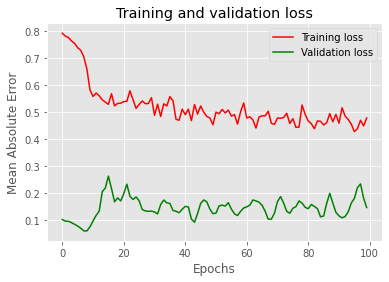

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = history.epoch

plt.figure()
plt.plot(epoch, loss, 'r', label='Training loss')
plt.plot(epoch, val_loss, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [38]:
loss_and_metrics = model.evaluate(X_test_60,y_test_60)
print('##### data 60 #####')
print('loss : ',loss_and_metrics)

1/1 [==============================] - 0s 34ms/step - loss: 0.6982
##### data 60 #####
loss :  0.6981623768806458


#Data 60 66 Bulid Model

In [39]:
model = Sequential()
model.add(LSTM(32, dropout=0.2, activation='relu', input_shape=(3,8), return_sequences=True))
model.add(LSTM(16, dropout=0.2, activation='relu'))
model.add(Dense(1, activation='linear'))

In [40]:
model.compile(optimizer='adam', loss='mae')

In [41]:
model_path = './model_60/{epoch:02d}-{val_loss:.4f}.hdf5'
callbacks = [EarlyStopping(monitor='val_loss', patience=30),
               ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=0, save_best_only=True)]
               
history = model.fit(X_train_both, y_train_60, epochs=100, batch_size=4, validation_data=(X_val_both, y_val_60))

Epoch 1/100
8/8 [==============================] - 4s 65ms/step - loss: 0.7940 - val_loss: 0.1464
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.7815 - val_loss: 0.1223
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.7686 - val_loss: 0.0997
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 0.7532 - val_loss: 0.0675
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.7248 - val_loss: 0.0539
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 0.7016 - val_loss: 0.0661
Epoch 7/100
8/8 [==============================] - 0s 10ms/step - loss: 0.6699 - val_loss: 0.0843
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 0.5913 - val_loss: 0.1305
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 0.5268 - val_loss: 0.1471
Epoch 10/100
8/8 [==============================] - 0s 8ms/step - loss: 0.5614 - val_loss: 0.1885
Epoch 11/100
8/8 [========

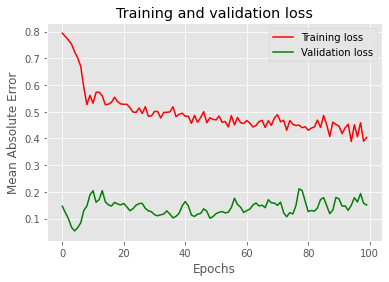

In [42]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = history.epoch

plt.figure()
plt.plot(epoch, loss, 'r', label='Training loss')
plt.plot(epoch, val_loss, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [45]:
loss_and_metrics = model.evaluate(X_test_both,y_test_60)
print('##### data 60 #####')
print('loss : ',loss_and_metrics)

1/1 [==============================] - 0s 95ms/step - loss: 0.7220
##### data 60 #####
loss :  0.722037136554718
